In [1]:
import os
import cv2
import numpy as np
import glob
from PIL import Image, ImageFilter
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
import seaborn as sns 

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler

2022-11-26 13:04:11.513024: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Segmentation Models: using `keras` framework.


# Reading the Data

In [2]:
# importing the tram_csv
tram_df = pd.read_csv('tram_filenames.csv')
tram_df.drop(columns=tram_df.columns[0], axis=1, inplace=True)
tram_jpg = np.array(tram_df.filename_jpg)
tram_jpg

array(['rs02096.jpg', 'rs07844.jpg', 'rs06555.jpg', ..., 'rs08401.jpg',
       'rs06969.jpg', 'rs05051.jpg'], dtype=object)

In [57]:
len(tram_df.filename_mask.unique())

1318

In [3]:
i = 'rs02094.jpg'
if i in tram_jpg:
    print('yes')
else:
    print('nix')

nix


In [17]:
# Setting up the directory for the files 
path_masks = '/Users/arasdirekoglu/Documents/Studium/Master/HTW - MPMD/3. Semester/MPMD 3.1. PM & Data Analytics Lab/02_Project/00_data/rs19_val/uint8/rs19_val/'
path_images = '/Users/arasdirekoglu/Documents/Studium/Master/HTW - MPMD/3. Semester/MPMD 3.1. PM & Data Analytics Lab/02_Project/00_data/rs19_val/jpgs/rs19_val/' 

# Setting up a breaker for test run 
#breaker = 0

# Setting up empty lists for image & mask dataset 
image_dataset = []
mask_dataset = []

# Setting up the label of interest: 
label_of_interest = 8 #veg

# For loop 
for filename in os.listdir(path_images):
    if filename.endswith('.jpg') and filename in tram_jpg:
        image = Image.open(path_images+filename)
        image = image.filter(ImageFilter.MedianFilter(size=3))
        image = np.array(image.resize((512, 256),Image.NEAREST))
        mask = Image.open(path_masks+filename[:7]+'.png')
        mask = mask.filter(ImageFilter.MedianFilter(size=3))
        mask = np.array(mask.resize((512,256),Image.NEAREST))
        mask = np.expand_dims(mask, axis=2)
        for layer in range(len(mask[0,0,:])):
            #mask[:int(256/2),:,layer]=0
            mask[:,:,layer][mask[:,:,layer]!=label_of_interest]=0
            mask[:,:,layer][mask[:,:,layer]==label_of_interest]=1
        image_dataset.append(image)
        mask_dataset.append(mask)

image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)
mask_dataset = mask_dataset[:,:,:,0]
print('image: ', image_dataset.shape)
print('mask: ', mask_dataset.shape)

mask_dataset = np.expand_dims(mask_dataset, axis=3)
print('image: ', image_dataset.shape)
print('mask: ', mask_dataset.shape)

print('unique labels in mask', np.unique(mask_dataset))

/var/folders/bs/ht_t1wp94tl3wt5xhchcxq2m0000gn/T/ipykernel_82972/1283493737.py:20: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  image = np.array(image.resize((512, 256),Image.NEAREST))
/var/folders/bs/ht_t1wp94tl3wt5xhchcxq2m0000gn/T/ipykernel_82972/1283493737.py:23: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  mask = np.array(mask.resize((512,256),Image.NEAREST))


image:  (1318, 256, 512, 3)
mask:  (1318, 256, 512)
image:  (1318, 256, 512, 3)
mask:  (1318, 256, 512, 1)
unique labels in mask [0 1]


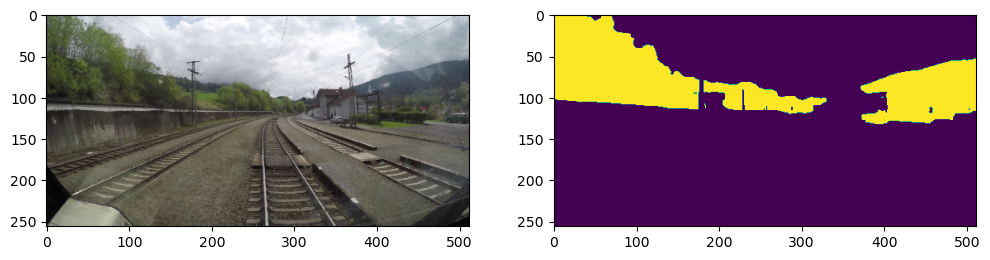

In [18]:
# Sanity check: Do images and masks match? 
#image_number = np.random.randint(0,len(image_dataset))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(image_dataset[827])
plt.subplot(122)
plt.imshow(mask_dataset[827])
plt.show()


In [19]:
image_number

827

# Split of Data

In [20]:
# split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)


# Model

In [21]:
# Preprocessing
# https://segmentation-models.readthedocs.io/en/latest/tutorial.html#models-and-backbones
BACKBONE = 'resnet18'
preprocess_input = sm.get_preprocessing(BACKBONE)

X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [22]:
# define the model
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5),'accuracy']
model = sm.Unet(BACKBONE, encoder_weights='imagenet', encoder_freeze = True, classes=1)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)

print(model.summary())

2022-11-26 13:52:19.187414: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

In [23]:
history = model.fit(    X_train,
                        y_train,
                        batch_size=20,
                        epochs=1,
                        verbose=1,
                        validation_data=(X_test,y_test))

53/53 [==============================] - 687s 13s/step - loss: 0.2606 - iou_score: 0.6324 - f1-score: 0.7665 - accuracy: 0.9150 - val_loss: 0.5136 - val_iou_score: 0.5620 - val_f1-score: 0.7174 - val_accuracy: 0.8936


1/1 [==============================] - 0s 206ms/step


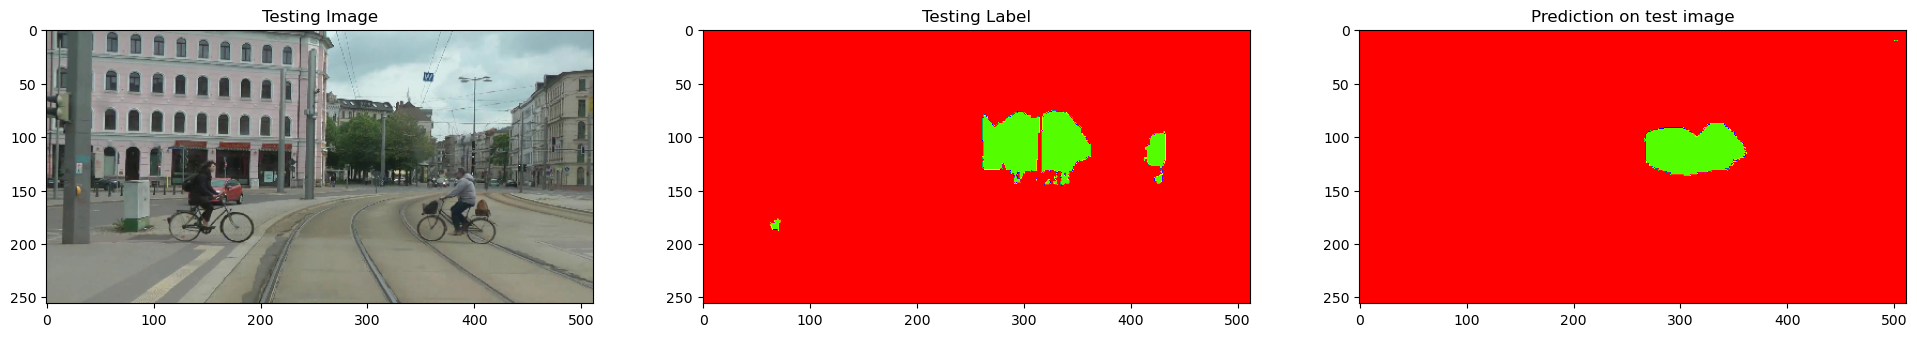

In [32]:
test_img_number = np.random.randint(0, len(X_test))
#test_img_number = 260
test_img = X_test[test_img_number]
test_img_to_show = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0) #this is to make (256, 512, 1) -> (1, 256, 512, 1)
prediction = (model.predict(test_img_input))
my_threshold = 0.8
predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img_to_show[:,:,:]) #the X_train and test has been processed wrt the BACKBONE above
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='prism')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='prism')
plt.show()

In [25]:
test_img_number

236

In [26]:
# 65, 13, 260, 162, 183, 14, 6 

1/1 [==============================] - 1s 966ms/step


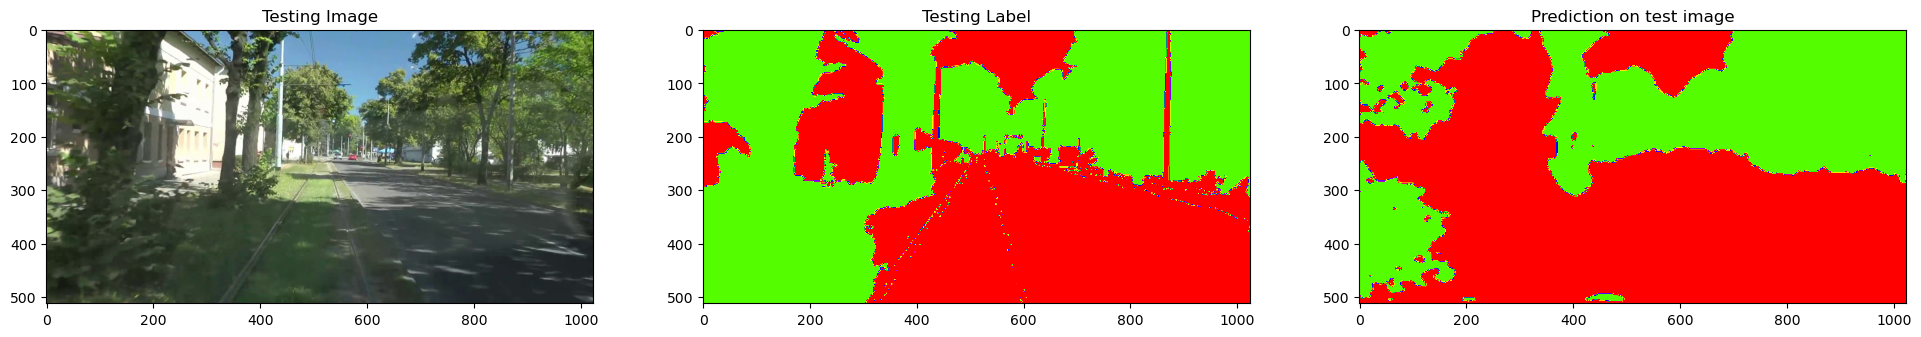

In [27]:
rsimage = Image.open(path_images+'rs00230.jpg')
rsimage = np.array(rsimage.resize((1024, 512),3))
rsimage_input=np.expand_dims(rsimage, 0)

rs_ground = Image.open(path_masks+'rs00230.png')
rs_ground = np.array(rs_ground.resize((1024, 512),3))
rs_ground = np.expand_dims(rs_ground, axis=2)
for layer in range(len(rs_ground[0,0,:])):
    rs_ground[:,:,layer][rs_ground[:,:,layer]!=label_of_interest]=0
    rs_ground[:,:,layer][rs_ground[:,:,layer]==label_of_interest]=1

prediction = (model.predict(rsimage_input))
my_threshold = 0.8
predicted_img=(prediction>=my_threshold).astype(int)[0,:,:,:] #remove the first axis

plt.figure(figsize=(24, 16))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(rsimage_input[0,:,:,:]) #the X_train and test has been processed wrt the BACKBONE above
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(rs_ground[:,:,0], cmap='prism')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='prism')
plt.show()